In [ ]:
# References: https://blog.evjang.com/2018/01/nf2.html , https://github.com/ericjang/normalizing-flows-tutorial/blob/master/nf_part2_modern.ipynb

In [ ]:
# Dataset 1: moons

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf


In [5]:
import tensorflow.compat.v1 as tf1
tf1.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [6]:
# tfd = tf.compat.v1.distributions
# tfb = tfd.bijectors
layers = tf.compat.v1.layers
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

In [7]:
tf.random.set_seed(0)

In [8]:
sess = tf.compat.v1.InteractiveSession()

In [ ]:
#model 1: MAF ( Masked Autoregressive Flow )

In [44]:
DTYPE=tf.float32
NP_DTYPE=np.float32
MODEL = 'MAF' # Which Normalizing Flow to use. 'NVP' or 'MAF' or 'IAF'
TARGET_DENSITY = 'MOONS' # Which dataset to model. 'MOONS' or 'SIGGRAPH' or 'GAUSSIAN'
USE_BATCHNORM = False

In [33]:
# dataset-specific settings
settings = {
    'MOONS': {
        'batch_size': 100,
        'num_bijectors': 4,
        'train_iters': 2e5
    }
}

In [ ]:
# reading train data from csv file as the inputs to the model: 
import pandas as pd
df = pd.read_csv('moons_train.csv')
df

,Index,x1,x2
0,0,1.788757,-0.156274
1,1,-0.945484,0.423333
2,2,1.690320,-0.389531
3,3,1.710316,-0.168995
4,4,-0.697539,0.664852
...,...,...,...
4245,4245,0.671945,0.656292
4246,4246,1.989923,0.057351
4247,4247,0.811150,-0.437442
4248,4248,-0.493136,0.885707


In [ ]:
df['x2'].to_numpy()

array([-0.15627375,  0.4233325 , -0.38953128, ..., -0.43744212,
        0.8857071 , -0.55471814])

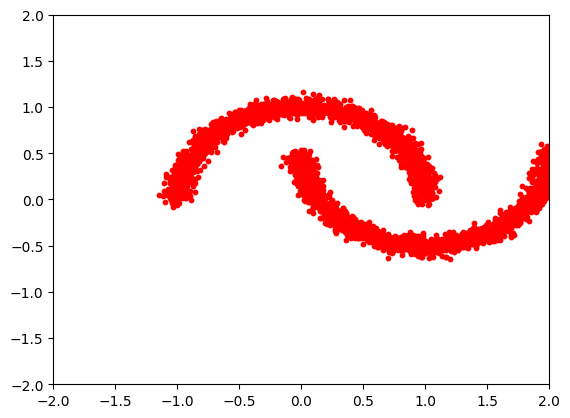

In [ ]:
if TARGET_DENSITY == 'MOONS':
    x2_samples = df['x2'].to_numpy()
    x1_samples = df['x1'].to_numpy()
    x_samples = tf.stack([x1_samples, x2_samples], axis=1)
    np_samples = sess.run(x_samples)
    plt.scatter(np_samples[:, 0], np_samples[:, 1], s=10, color='red')
    plt.xlim([-2, 2])
    plt.ylim([-2, 2]) 

In [ ]:
x_samples

<tf.Tensor 'IteratorGetNext_2:0' shape=(?, 2) dtype=float32>

In [ ]:
from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler
n_samples = 4250
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
X, y = noisy_moons
X = StandardScaler().fit_transform(X)
xlim, ylim = [-2, 2], [-2, 2]

dataset = tf.compat.v1.data.Dataset.from_tensor_slices(X.astype(NP_DTYPE))
dataset = dataset.repeat()
dataset = dataset.shuffle(buffer_size=X.shape[0])
dataset = dataset.prefetch(3 * settings[TARGET_DENSITY]['batch_size'])
dataset = dataset.batch(settings[TARGET_DENSITY]['batch_size'])
data_iterator = dataset.make_one_shot_iterator()
x_samples = data_iterator.get_next()

In [40]:
def net(x, out_size):
    return layers.stack(x, layers.fully_connected, [512, 512, out_size])

# Affine Coupling layer for Real-NVP

class NVPCoupling(tfb.Bijector):
    """NVP affine coupling layer for 2D units.
    """

    def __init__(self, D, d, layer_id=0, validate_args=False, name="NVPCoupling"):
        """
        Args:
          d: First d units are pass-thru units.
        """
        # first d numbers decide scaling/shift factor for remaining D-d numbers.
        super(NVPCoupling, self).__init__(
            event_ndims=1, validate_args=validate_args, name=name)
        self.D, self.d = D, d
        self.id = layer_id
        # create variables here
        tmp = tf.placeholder(dtype=DTYPE, shape=[1, self.d])
        self.s(tmp)
        self.t(tmp)

    def s(self, xd):
        with tf.variable_scope('s%d' % self.id, reuse=tf.AUTO_REUSE):
            return net(xd, self.D - self.d)

    def t(self, xd):
        with tf.variable_scope('t%d' % self.id, reuse=tf.AUTO_REUSE):
            return net(xd, self.D - self.d)

    def _forward(self, x):
        xd, xD = x[:, :self.d], x[:, self.d:]
        yD = xD * tf.exp(self.s(xd)) + self.t(xd)  # [batch, D-d]
        return tf.concat([xd, yD], axis=1)

    def _inverse(self, y):
        yd, yD = y[:, :self.d], y[:, self.d:]
        xD = (yD - self.t(yd)) * tf.exp(-self.s(yd))
        return tf.concat([yd, xD], axis=1)

    def _forward_log_det_jacobian(self, x):
        event_dims = self._event_dims_tensor(x)
        xd = x[:, :self.d]
        return tf.reduce_sum(self.s(xd), axis=event_dims)


In [41]:
class BatchNorm(tfb.Bijector):
    def __init__(self, eps=1e-5, decay=0.95, validate_args=False, name="batch_norm"):
        super(BatchNorm, self).__init__(
            event_ndims=1, validate_args=validate_args, name=name)
        self._vars_created = False
        self.eps = eps
        self.decay = decay

    def _create_vars(self, x):
        n = x.get_shape().as_list()[1]
        with tf.variable_scope(self.name):
            self.beta = tf.get_variable('beta', [1, n], dtype=DTYPE)
            self.gamma = tf.get_variable('gamma', [1, n], dtype=DTYPE)
            self.train_m = tf.get_variable(
                'mean', [1, n], dtype=DTYPE, trainable=False)
            self.train_v = tf.get_variable(
                'var', [1, n], dtype=DTYPE, initializer=tf.ones_initializer, trainable=False)
        self._vars_created = True

    def _forward(self, u):
        if not self._vars_created:
            self._create_vars(u)
        return (u - self.beta) * tf.exp(-self.gamma) * tf.sqrt(self.train_v + self.eps) + self.train_m

    def _inverse(self, x):
        # Eq 22. Called during training of a normalizing flow.
        if not self._vars_created:
            self._create_vars(x)
        # statistics of current minibatch
        m, v = tf.nn.moments(x, axes=[0], keep_dims=True)
        # update train statistics via exponential moving average
        update_train_m = tf.assign_sub(
            self.train_m, self.decay * (self.train_m - m))
        update_train_v = tf.assign_sub(
            self.train_v, self.decay * (self.train_v - v))
        # normalize using current minibatch statistics, followed by BN scale and shift
        with tf.control_dependencies([update_train_m, update_train_v]):
            return (x - m) * 1. / tf.sqrt(v + self.eps) * tf.exp(self.gamma) + self.beta

    def _inverse_log_det_jacobian(self, x):
        # at training time, the log_det_jacobian is computed from statistics of the
        # current minibatch.
        if not self._vars_created:
            self._create_vars(x)
        _, v = tf.nn.moments(x, axes=[0], keep_dims=True)
        abs_log_det_J_inv = tf.reduce_sum(
            self.gamma - .5 * tf.log(v + self.eps))
        return abs_log_det_J_inv

In [ ]:
# Construct Flow

In [42]:
base_dist = tfd.MultivariateNormalDiag(loc=tf.zeros([2], DTYPE))

Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.


In [45]:
num_bijectors = settings[TARGET_DENSITY]['num_bijectors']
bijectors = []

for i in range(num_bijectors):
    if MODEL == 'NVP':
        bijectors.append(NVPCoupling(D=2, d=1, layer_id=i))
    elif MODEL == 'MAF':
        bijectors.append(tfb.MaskedAutoregressiveFlow(
            shift_and_log_scale_fn=tfb.masked_autoregressive_default_template(
                hidden_layers=[512, 512])))
    elif MODEL == 'IAF':
        bijectors.append(tfb.Invert(tfb.MaskedAutoregressiveFlow(
            shift_and_log_scale_fn=tfb.masked_autoregressive_default_template(
                hidden_layers=[512, 512]))))
    if USE_BATCHNORM and i % 2 == 0:
        # BatchNorm helps to stabilize deep normalizing flows, esp. Real-NVP
        bijectors.append(BatchNorm(name='batch_norm%d' % i))
    bijectors.append(tfb.Permute(permutation=[1, 0]))
# Discard the last Permute layer.
flow_bijector = tfb.Chain(list(reversed(bijectors[:-1])))

Instructions for updating:
`masked_autoregressive_default_template` is deprecated; use `tfp.bijectors.AutoregressiveNetwork`.   Also, please note the section "Variable Tracking" in the documentation for `tfp.bijectors.MaskedAutoregressiveFlow`.


In [31]:
dist = tfd.TransformedDistribution(
    distribution=base_dist,
    bijector=flow_bijector)

In [32]:
# visualization (before training)
x = base_dist.sample(8000)
samples = [x]
names = [base_dist.name]
for bijector in reversed(dist.bijector.bijectors):
    x = bijector.forward(x)
    samples.append(x)
    names.append(bijector.name)

In [33]:
sess.run(tf.compat.v1.global_variables_initializer())

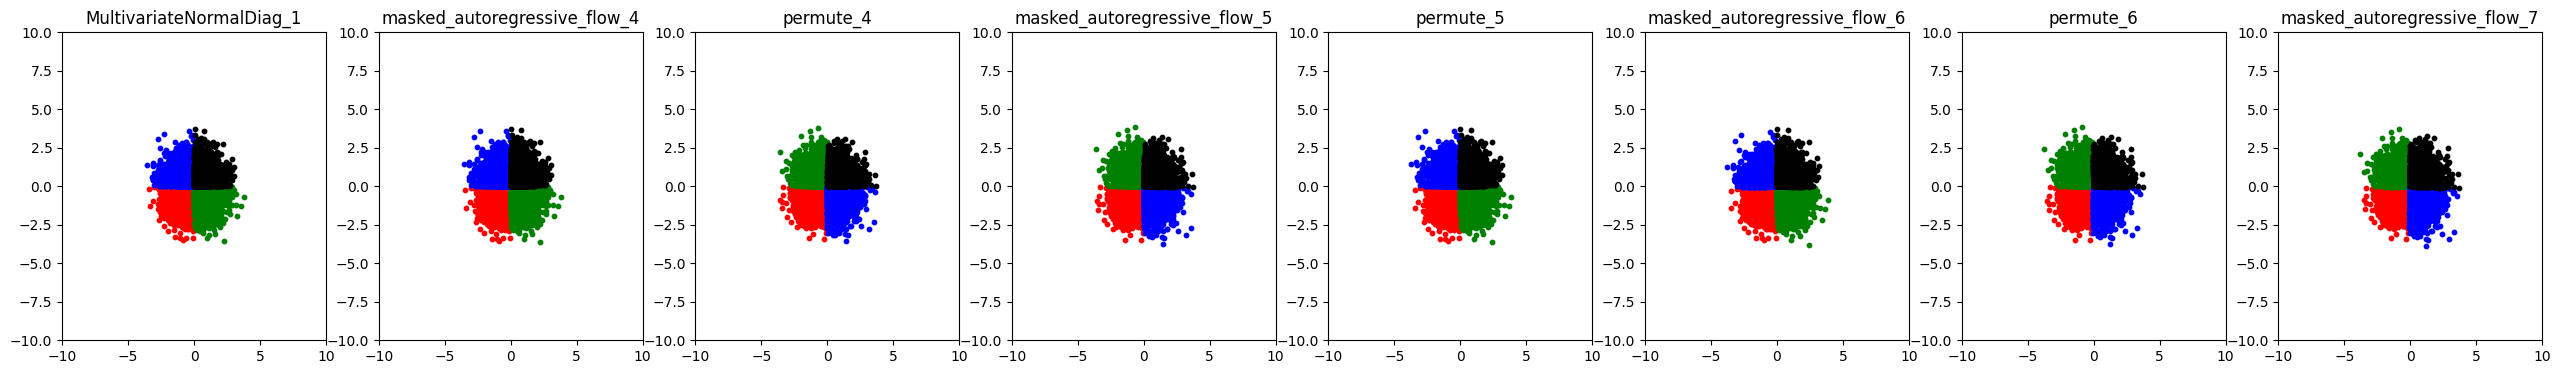

In [34]:
results = sess.run(samples)
f, arr = plt.subplots(1, len(results), figsize=(4 * (len(results)), 4))
X0 = results[0]
for i in range(len(results)):
    X1 = results[i]
    idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] < 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='red')
    idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] < 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='green')
    idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] > 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='blue')
    idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] > 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='black')
    arr[i].set_xlim([-10, 10])
    arr[i].set_ylim([-10, 10])
    arr[i].set_title(names[i])

In [ ]:
# Optimize Flow

In [35]:
loss = -tf.reduce_mean(dist.log_prob(x_samples))
train_op = tf.compat.v1.train.AdamOptimizer(1e-4).minimize(loss)

In [36]:
sess.run(tf.compat.v1.global_variables_initializer())

0 2.874067
10000 1.1724749
20000 1.1751192
30000 1.0537506
40000 1.073832
50000 1.1531551
60000 1.0906723
70000 1.1430095
80000 1.1449605
90000 1.1309233
100000 1.0434575
110000 1.212529
120000 1.0873199
130000 0.9919989
140000 1.2628533
150000 1.1433315
160000 1.0351306
170000 0.98611945
180000 1.0108387
190000 0.9588481


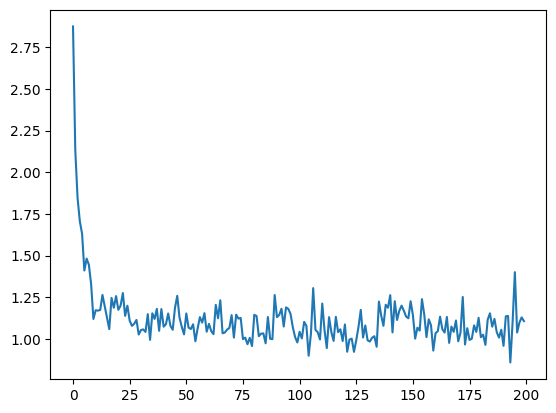

In [37]:
# training the model for 20 epochs and generating loss plot
NUM_STEPS = int(settings[TARGET_DENSITY]['train_iters'])
global_step = []
np_losses = []
for i in range(NUM_STEPS):
    _, np_loss = sess.run([train_op, loss])
    if i % 1000 == 0:
        global_step.append(i)
        np_losses.append(np_loss)
    if i % int(1e4) == 0:
        print(i, np_loss)
start = 0
plt.plot(np_losses[start:])

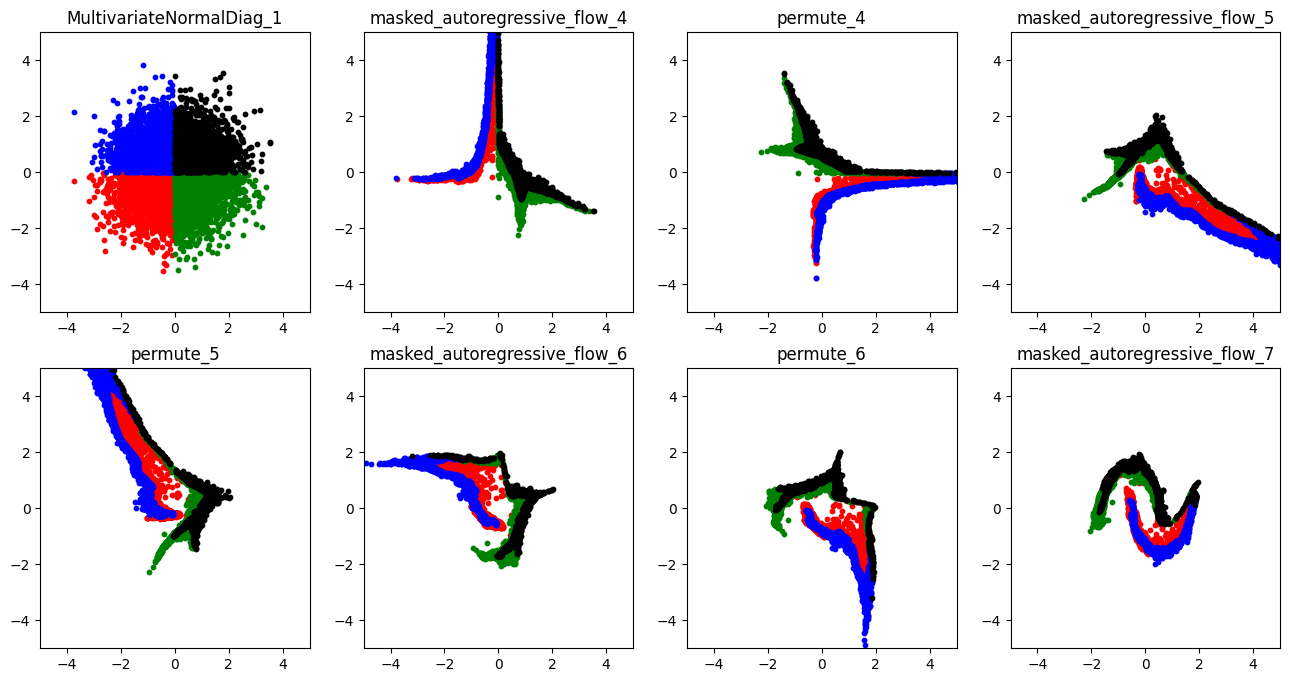

In [38]:
results = sess.run(samples)
X0 = results[0]
rows = 2
cols = int(len(results) / 2)
f, arr = plt.subplots(2, cols, figsize=(4 * (cols), 4 * rows))
i = 0
for r in range(rows):
    for c in range(cols):
        X1 = results[i]
        idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] < 0)
        arr[r, c].scatter(X1[idx, 0], X1[idx, 1], s=10, color='red')
        idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] < 0)
        arr[r, c].scatter(X1[idx, 0], X1[idx, 1], s=10, color='green')
        idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] > 0)
        arr[r, c].scatter(X1[idx, 0], X1[idx, 1], s=10, color='blue')
        idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] > 0)
        arr[r, c].scatter(X1[idx, 0], X1[idx, 1], s=10, color='black')
        arr[r, c].set_xlim([-5, 5])
        arr[r, c].set_ylim([-5, 5])
        arr[r, c].set_title(names[i])

        i += 1
plt.savefig('moons_trained.png', dpi=300)

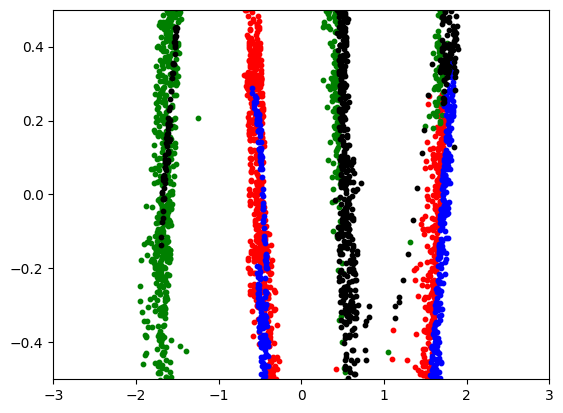

In [39]:
# plot the last one, scaled up
idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] < 0)
plt.scatter(X1[idx, 0], X1[idx, 1], s=10, color='red')
idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] < 0)
plt.scatter(X1[idx, 0], X1[idx, 1], s=10, color='green')
idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] > 0)
plt.scatter(X1[idx, 0], X1[idx, 1], s=10, color='blue')
idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] > 0)
plt.scatter(X1[idx, 0], X1[idx, 1], s=10, color='black')
plt.xlim([-3, 3])
plt.ylim([-.5, .5])
plt.savefig('moons_out.png', dpi=300)

In [ ]:
# Model 2: IAF (Inverse Autoregressive Flow)

In [17]:
DTYPE=tf.float32
NP_DTYPE=np.float32
MODEL = 'IAF' # Which Normalizing Flow to use. 'NVP' or 'MAF' or 'IAF'
TARGET_DENSITY = 'MOONS' # Which dataset to model. 'MOONS' or 'SIGGRAPH' or 'GAUSSIAN'
USE_BATCHNORM = False

(-2.0, 2.0)

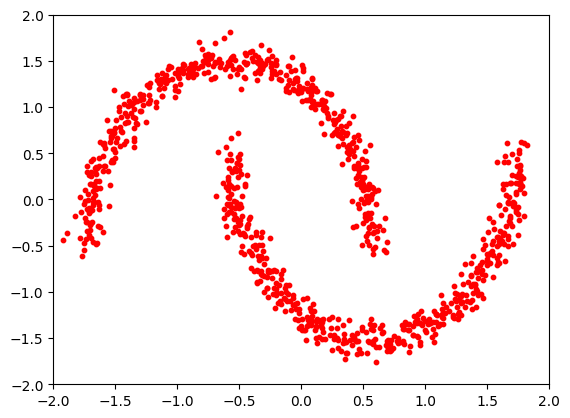

In [9]:
if TARGET_DENSITY == 'MOONS':
    from sklearn import cluster, datasets, mixture
    from sklearn.preprocessing import StandardScaler
    n_samples = 1000
    noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
    X, y = noisy_moons
    X = StandardScaler().fit_transform(X)
    xlim, ylim = [-2, 2], [-2, 2]

plt.scatter(X[:, 0], X[:, 1], s=10, color='red')
plt.xlim(xlim)
plt.ylim(ylim)

In [18]:
dataset = tf.compat.v1.data.Dataset.from_tensor_slices(X.astype(NP_DTYPE))
dataset = dataset.repeat()
dataset = dataset.shuffle(buffer_size=X.shape[0])
dataset = dataset.prefetch(3 * settings[TARGET_DENSITY]['batch_size'])
dataset = dataset.batch(settings[TARGET_DENSITY]['batch_size'])
data_iterator = dataset.make_one_shot_iterator()
x_samples = data_iterator.get_next()

In [ ]:
# Construct Flow

In [19]:
base_dist = tfd.MultivariateNormalDiag(loc=tf.zeros([2], DTYPE))

In [20]:
num_bijectors = settings[TARGET_DENSITY]['num_bijectors']
bijectors = []

for i in range(num_bijectors):
    if MODEL == 'NVP':
        bijectors.append(NVPCoupling(D=2, d=1, layer_id=i))
    elif MODEL == 'MAF':
        bijectors.append(tfb.MaskedAutoregressiveFlow(
            shift_and_log_scale_fn=tfb.masked_autoregressive_default_template(
                hidden_layers=[512, 512])))
    elif MODEL == 'IAF':
        bijectors.append(tfb.Invert(tfb.MaskedAutoregressiveFlow(
            shift_and_log_scale_fn=tfb.masked_autoregressive_default_template(
                hidden_layers=[512, 512]))))
    if USE_BATCHNORM and i % 2 == 0:
        # BatchNorm helps to stabilize deep normalizing flows, esp. Real-NVP
        bijectors.append(BatchNorm(name='batch_norm%d' % i))
    bijectors.append(tfb.Permute(permutation=[1, 0]))
# Discard the last Permute layer.
flow_bijector = tfb.Chain(list(reversed(bijectors[:-1])))

Instructions for updating:
`masked_autoregressive_default_template` is deprecated; use `tfp.bijectors.AutoregressiveNetwork`.   Also, please note the section "Variable Tracking" in the documentation for `tfp.bijectors.MaskedAutoregressiveFlow`.


In [21]:
dist = tfd.TransformedDistribution(
    distribution=base_dist,
    bijector=flow_bijector)

In [22]:
# visualization (before training)
x = base_dist.sample(8000)
samples = [x]
names = [base_dist.name]
for bijector in reversed(dist.bijector.bijectors):
    x = bijector.forward(x)
    samples.append(x)
    names.append(bijector.name)

In [23]:
sess.run(tf.compat.v1.global_variables_initializer())

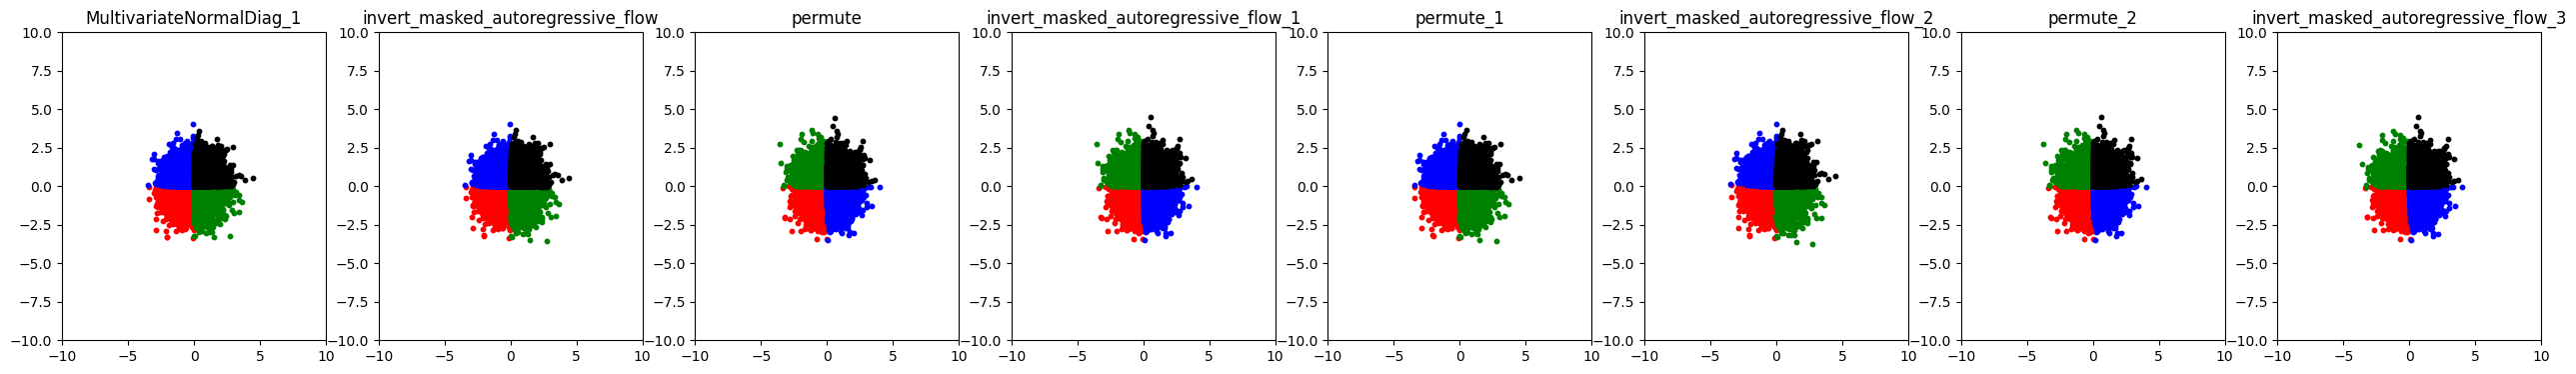

In [24]:
results = sess.run(samples)
f, arr = plt.subplots(1, len(results), figsize=(4 * (len(results)), 4))
X0 = results[0]
for i in range(len(results)):
    X1 = results[i]
    idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] < 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='red')
    idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] < 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='green')
    idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] > 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='blue')
    idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] > 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='black')
    arr[i].set_xlim([-10, 10])
    arr[i].set_ylim([-10, 10])
    arr[i].set_title(names[i])

In [ ]:
# Optimize Flow

In [25]:
loss = -tf.reduce_mean(dist.log_prob(x_samples))
train_op = tf.compat.v1.train.AdamOptimizer(1e-4).minimize(loss)

In [26]:
sess.run(tf.compat.v1.global_variables_initializer())

0 2.8059528
10000 1.2889955
20000 1.1988597
30000 1.0984875
40000 2.1085167
50000 3.9286392
60000 1918.2314
70000 4173.2495
80000 9729.164
90000 14219.025
100000 17730.42
110000 20246.53
120000 22156.71
130000 23225.432
140000 22814.932
150000 22917.186
160000 21148.016
170000 19664.127
180000 18749.19
190000 16785.748


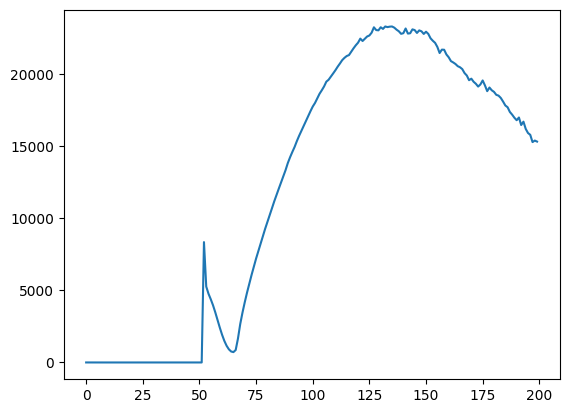

In [27]:
# training the model for 20 epochs and generating loss plot
NUM_STEPS = int(settings[TARGET_DENSITY]['train_iters'])
global_step = []
np_losses = []
for i in range(NUM_STEPS):
    _, np_loss = sess.run([train_op, loss])
    if i % 1000 == 0:
        global_step.append(i)
        np_losses.append(np_loss)
    if i % int(1e4) == 0:
        print(i, np_loss)
start = 0
plt.plot(np_losses[start:])

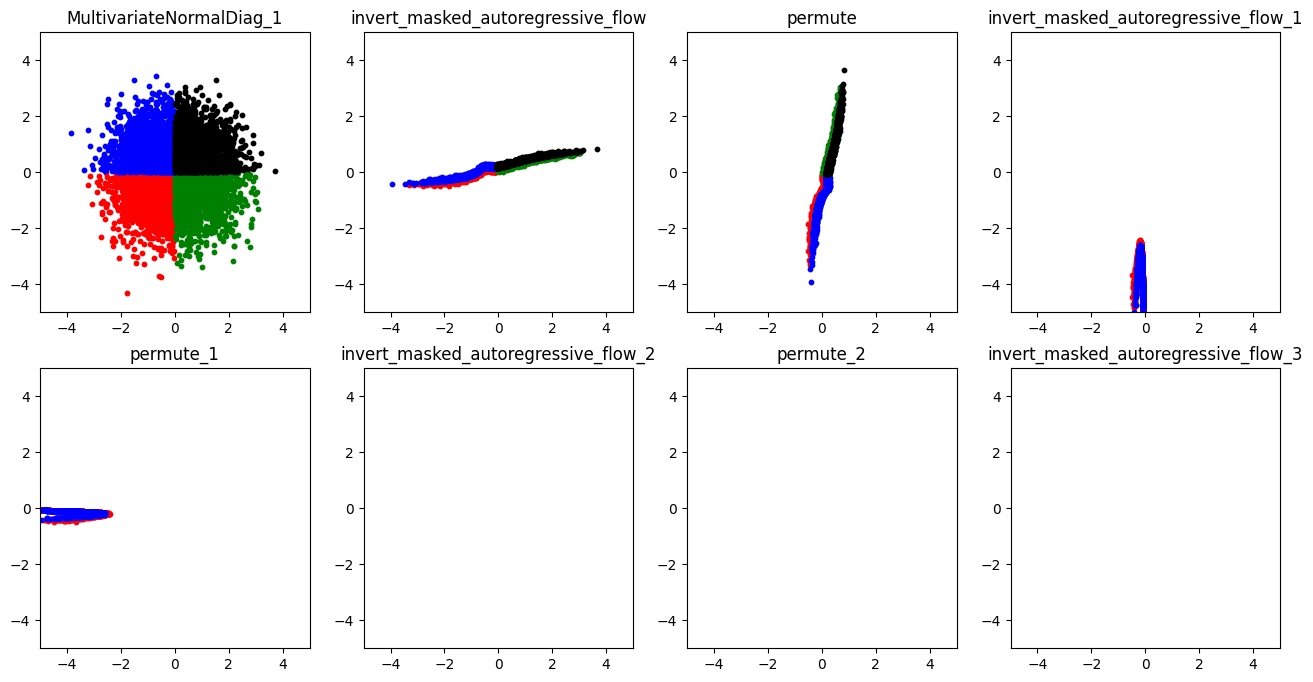

In [28]:
results = sess.run(samples)
X0 = results[0]
rows = 2
cols = int(len(results) / 2)
f, arr = plt.subplots(2, cols, figsize=(4 * (cols), 4 * rows))
i = 0
for r in range(rows):
    for c in range(cols):
        X1 = results[i]
        idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] < 0)
        arr[r, c].scatter(X1[idx, 0], X1[idx, 1], s=10, color='red')
        idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] < 0)
        arr[r, c].scatter(X1[idx, 0], X1[idx, 1], s=10, color='green')
        idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] > 0)
        arr[r, c].scatter(X1[idx, 0], X1[idx, 1], s=10, color='blue')
        idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] > 0)
        arr[r, c].scatter(X1[idx, 0], X1[idx, 1], s=10, color='black')
        arr[r, c].set_xlim([-5, 5])
        arr[r, c].set_ylim([-5, 5])
        arr[r, c].set_title(names[i])

        i += 1
plt.savefig('moons_trained.png', dpi=300)

In [23]:
# dataset 2: circles->

In [9]:
# tfd = tf.compat.v1.distributions
# tfb = tfd.bijectors
layers = tf.compat.v1.layers
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

In [10]:
tf.random.set_seed(0)

In [11]:
sess = tf.compat.v1.InteractiveSession()

/usr/local/lib/python3.9/dist-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [ ]:
# model 1: MAF( Masked Autoregressive Flow )

In [12]:
DTYPE=tf.float32
NP_DTYPE=np.float32
MODEL = 'MAF' # Which Normalizing Flow to use. 'NVP' or 'MAF' or 'IAF'
TARGET_DENSITY = 'CIRCLES' # Which dataset to model. 
USE_BATCHNORM = False

In [13]:
# dataset-specific settings
settings = {
    'CIRCLES': {
        'batch_size': 100,
        'num_bijectors': 4,
        'train_iters': 2e5
    }
}

In [2]:
# reading train data from csv file as the inputs to the model: 
import pandas as pd
df = pd.read_csv('circles_train.csv')
df

,Index,x1,x2
0,0,0.057297,-0.518857
1,1,-0.142669,0.926606
2,2,0.105939,0.449266
3,3,0.003570,-0.986790
4,4,-0.401354,-0.292471
...,...,...,...
4245,4245,-0.783529,0.549585
4246,4246,-0.330736,-0.352612
4247,4247,0.872725,-0.485027
4248,4248,-0.205234,0.996454


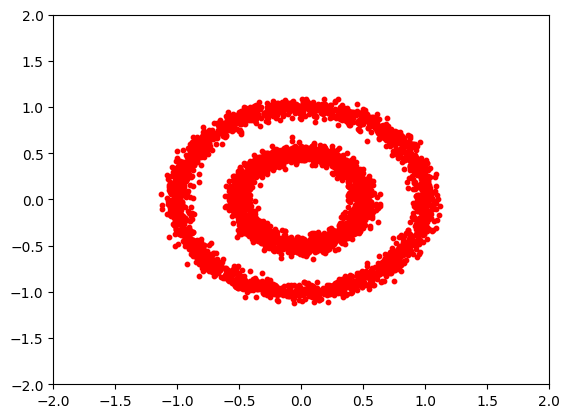

In [14]:
if TARGET_DENSITY == 'CIRCLES':
    x2_samples = df['x2'].to_numpy()
    x1_samples = df['x1'].to_numpy()
    x_samples = tf.stack([x1_samples, x2_samples], axis=1)
    np_samples = sess.run(x_samples)
    plt.scatter(np_samples[:, 0], np_samples[:, 1], s=10, color='red')
    plt.xlim([-2, 2])
    plt.ylim([-2, 2]) 

In [ ]:
from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler
n_samples = 1000
noisy_circles = datasets.make_circles(n_samples=n_samples, noise=.05)
X, y = noisy_circles
X = StandardScaler().fit_transform(X)
xlim, ylim = [-2, 2], [-2, 2]
plt.scatter(X[:, 0], X[:, 1], s=10, color='red')
plt.xlim(xlim)
plt.ylim(ylim)

dataset = tf.compat.v1.data.Dataset.from_tensor_slices(X.astype(NP_DTYPE))
dataset = dataset.repeat()
dataset = dataset.shuffle(buffer_size=X.shape[0])
dataset = dataset.prefetch(3 * settings[TARGET_DENSITY]['batch_size'])
dataset = dataset.batch(settings[TARGET_DENSITY]['batch_size'])
data_iterator = dataset.make_one_shot_iterator()
x_samples = data_iterator.get_next()

Instructions for updating:
This is a deprecated API that should only be used in TF 1 graph mode and legacy TF 2 graph mode available through `tf.compat.v1`. In all other situations -- namely, eager mode and inside `tf.function` -- you can consume dataset elements using `for elem in dataset: ...` or by explicitly creating iterator via `iterator = iter(dataset)` and fetching its elements via `values = next(iterator)`. Furthermore, this API is not available in TF 2. During the transition from TF 1 to TF 2 you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)` to create a TF 1 graph mode style iterator for a dataset created through TF 2 APIs. Note that this should be a transient state of your code base as there are in general no guarantees about the interoperability of TF 1 and TF 2 code.


In [10]:
def net(x, out_size):
    return layers.stack(x, layers.fully_connected, [512, 512, out_size])

# Affine Coupling layer for Real-NVP


class NVPCoupling(tfb.Bijector):
    """NVP affine coupling layer for 2D units.
    """

    def __init__(self, D, d, layer_id=0, validate_args=False, name="NVPCoupling"):
        """
        Args:
          d: First d units are pass-thru units.
        """
        # first d numbers decide scaling/shift factor for remaining D-d numbers.
        super(NVPCoupling, self).__init__(
            event_ndims=1, validate_args=validate_args, name=name)
        self.D, self.d = D, d
        self.id = layer_id
        # create variables here
        tmp = tf.placeholder(dtype=DTYPE, shape=[1, self.d])
        self.s(tmp)
        self.t(tmp)

    def s(self, xd):
        with tf.variable_scope('s%d' % self.id, reuse=tf.AUTO_REUSE):
            return net(xd, self.D - self.d)

    def t(self, xd):
        with tf.variable_scope('t%d' % self.id, reuse=tf.AUTO_REUSE):
            return net(xd, self.D - self.d)

    def _forward(self, x):
        xd, xD = x[:, :self.d], x[:, self.d:]
        yD = xD * tf.exp(self.s(xd)) + self.t(xd)  # [batch, D-d]
        return tf.concat([xd, yD], axis=1)

    def _inverse(self, y):
        yd, yD = y[:, :self.d], y[:, self.d:]
        xD = (yD - self.t(yd)) * tf.exp(-self.s(yd))
        return tf.concat([yd, xD], axis=1)

    def _forward_log_det_jacobian(self, x):
        event_dims = self._event_dims_tensor(x)
        xd = x[:, :self.d]
        return tf.reduce_sum(self.s(xd), axis=event_dims)


In [11]:
class BatchNorm(tfb.Bijector):
    def __init__(self, eps=1e-5, decay=0.95, validate_args=False, name="batch_norm"):
        super(BatchNorm, self).__init__(
            event_ndims=1, validate_args=validate_args, name=name)
        self._vars_created = False
        self.eps = eps
        self.decay = decay

    def _create_vars(self, x):
        n = x.get_shape().as_list()[1]
        with tf.variable_scope(self.name):
            self.beta = tf.get_variable('beta', [1, n], dtype=DTYPE)
            self.gamma = tf.get_variable('gamma', [1, n], dtype=DTYPE)
            self.train_m = tf.get_variable(
                'mean', [1, n], dtype=DTYPE, trainable=False)
            self.train_v = tf.get_variable(
                'var', [1, n], dtype=DTYPE, initializer=tf.ones_initializer, trainable=False)
        self._vars_created = True

    def _forward(self, u):
        if not self._vars_created:
            self._create_vars(u)
        return (u - self.beta) * tf.exp(-self.gamma) * tf.sqrt(self.train_v + self.eps) + self.train_m

    def _inverse(self, x):
        # Eq 22. Called during training of a normalizing flow.
        if not self._vars_created:
            self._create_vars(x)
        # statistics of current minibatch
        m, v = tf.nn.moments(x, axes=[0], keep_dims=True)
        # update train statistics via exponential moving average
        update_train_m = tf.assign_sub(
            self.train_m, self.decay * (self.train_m - m))
        update_train_v = tf.assign_sub(
            self.train_v, self.decay * (self.train_v - v))
        # normalize using current minibatch statistics, followed by BN scale and shift
        with tf.control_dependencies([update_train_m, update_train_v]):
            return (x - m) * 1. / tf.sqrt(v + self.eps) * tf.exp(self.gamma) + self.beta

    def _inverse_log_det_jacobian(self, x):
        # at training time, the log_det_jacobian is computed from statistics of the
        # current minibatch.
        if not self._vars_created:
            self._create_vars(x)
        _, v = tf.nn.moments(x, axes=[0], keep_dims=True)
        abs_log_det_J_inv = tf.reduce_sum(
            self.gamma - .5 * tf.log(v + self.eps))
        return abs_log_det_J_inv

In [ ]:
# Construct Flow

In [12]:
base_dist = tfd.MultivariateNormalDiag(loc=tf.zeros([2], DTYPE))

Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.


In [52]:
num_bijectors = settings[TARGET_DENSITY]['num_bijectors']
bijectors = []

for i in range(num_bijectors):
    if MODEL == 'NVP':
        bijectors.append(NVPCoupling(D=2, d=1, layer_id=i))
    elif MODEL == 'MAF':
        bijectors.append(tfb.MaskedAutoregressiveFlow(
            shift_and_log_scale_fn=tfb.masked_autoregressive_default_template(
                hidden_layers=[512, 512])))
    elif MODEL == 'IAF':
        bijectors.append(tfb.Invert(tfb.MaskedAutoregressiveFlow(
            shift_and_log_scale_fn=tfb.masked_autoregressive_default_template(
                hidden_layers=[512, 512]))))
    if USE_BATCHNORM and i % 2 == 0:
        # BatchNorm helps to stabilize deep normalizing flows, esp. Real-NVP
        bijectors.append(BatchNorm(name='batch_norm%d' % i))
    bijectors.append(tfb.Permute(permutation=[1, 0]))
# Discard the last Permute layer.
flow_bijector = tfb.Chain(list(reversed(bijectors[:-1])))

In [53]:
dist = tfd.TransformedDistribution(
    distribution=base_dist,
    bijector=flow_bijector)

In [54]:
# visualization (before training)
x = base_dist.sample(8000)
samples = [x]
names = [base_dist.name]
for bijector in reversed(dist.bijector.bijectors):
    x = bijector.forward(x)
    samples.append(x)
    names.append(bijector.name)

In [55]:
sess.run(tf.compat.v1.global_variables_initializer())

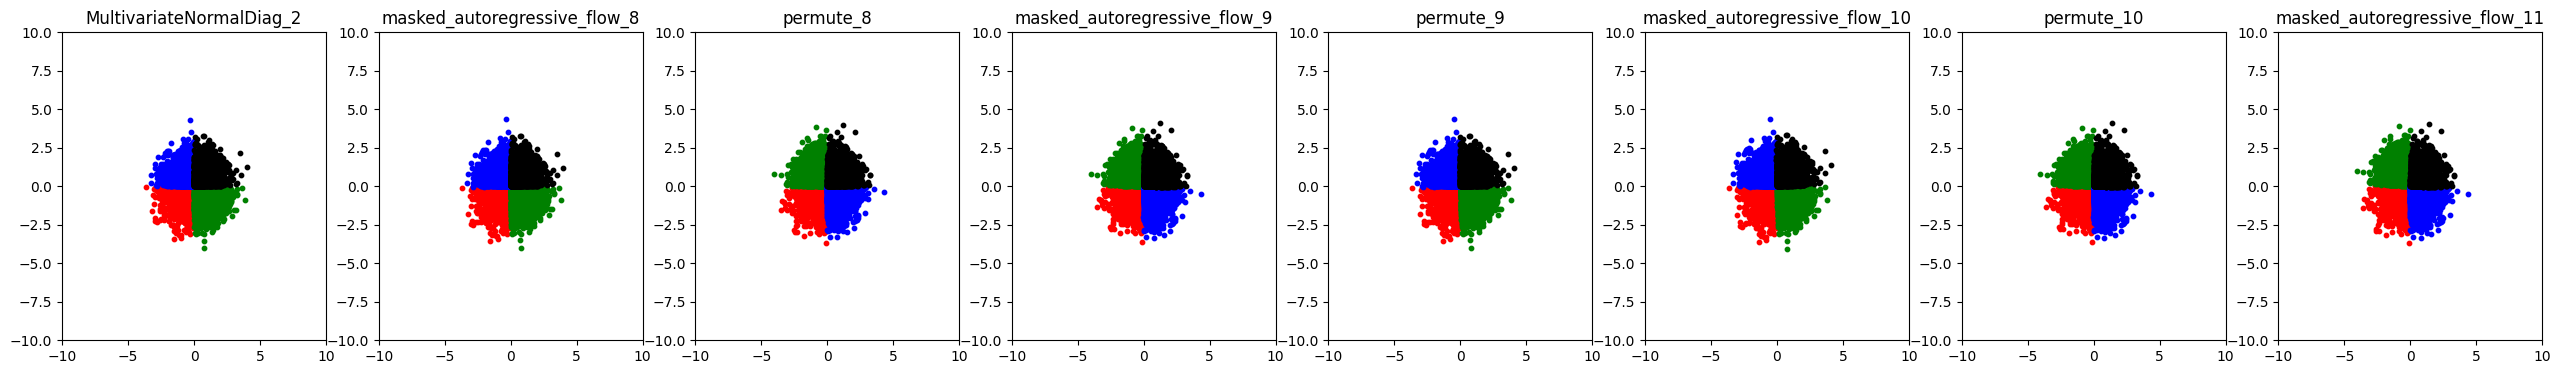

In [56]:
results = sess.run(samples)
f, arr = plt.subplots(1, len(results), figsize=(4 * (len(results)), 4))
X0 = results[0]
for i in range(len(results)):
    X1 = results[i]
    idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] < 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='red')
    idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] < 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='green')
    idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] > 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='blue')
    idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] > 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='black')
    arr[i].set_xlim([-10, 10])
    arr[i].set_ylim([-10, 10])
    arr[i].set_title(names[i])

In [ ]:
# Optimize Flow

In [57]:
loss = -tf.reduce_mean(dist.log_prob(x_samples))
train_op = tf.compat.v1.train.AdamOptimizer(1e-4).minimize(loss)

In [58]:
sess.run(tf.compat.v1.global_variables_initializer())

0 2.796684
10000 1.8641514
20000 1.6819023
30000 1.7745256
40000 1.7140797
50000 1.6640458
60000 1.6454371
70000 1.6874396
80000 1.6977617
90000 1.706773
100000 1.7860074
110000 1.651572
120000 1.5897199
130000 1.6267391
140000 1.6461579
150000 1.6478188
160000 1.7330768
170000 1.6219715
180000 1.7033159
190000 1.6620549


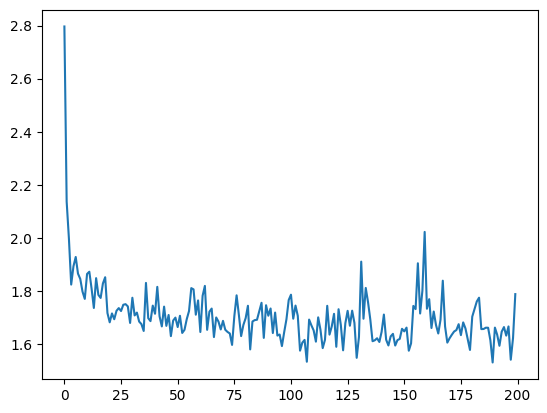

In [59]:
# training the model for 20 epochs and generating loss plot
NUM_STEPS = int(settings[TARGET_DENSITY]['train_iters'])
global_step = []
np_losses = []
for i in range(NUM_STEPS):
    _, np_loss = sess.run([train_op, loss])
    if i % 1000 == 0:
        global_step.append(i)
        np_losses.append(np_loss)
    if i % int(1e4) == 0:
        print(i, np_loss)
start = 0
plt.plot(np_losses[start:])

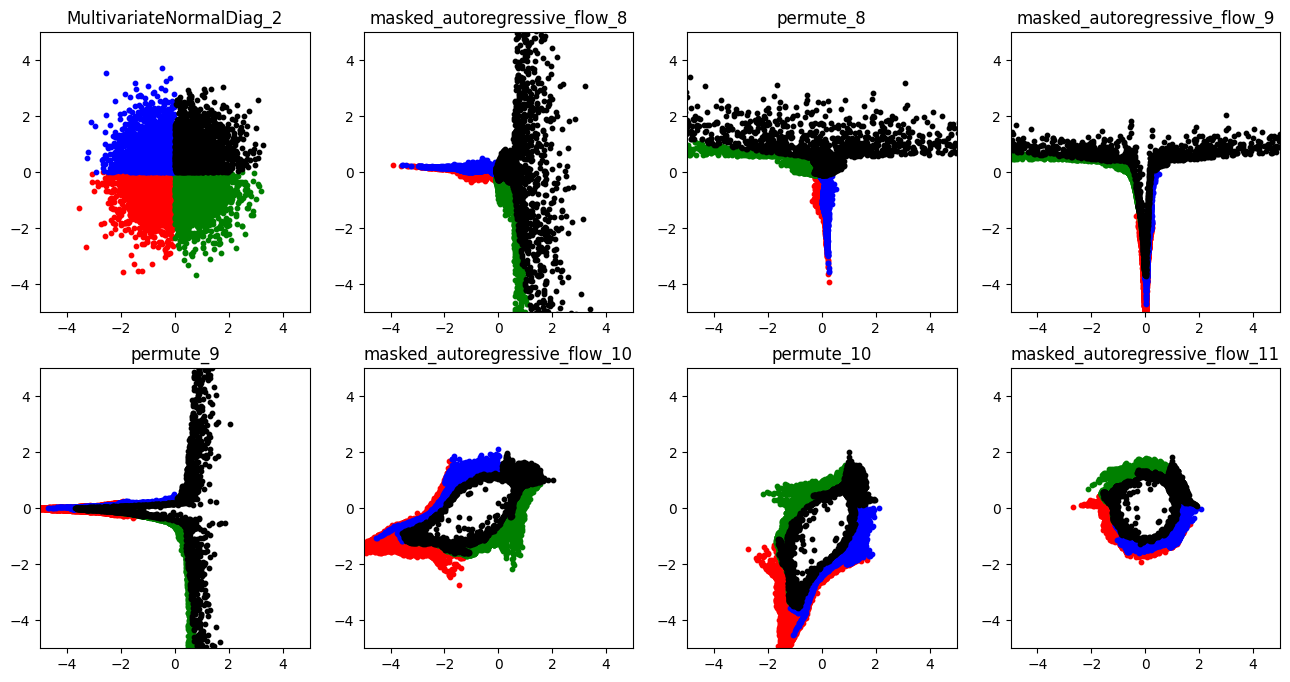

In [60]:
results = sess.run(samples)
X0 = results[0]
rows = 2
cols = int(len(results) / 2)
f, arr = plt.subplots(2, cols, figsize=(4 * (cols), 4 * rows))
i = 0
for r in range(rows):
    for c in range(cols):
        X1 = results[i]
        idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] < 0)
        arr[r, c].scatter(X1[idx, 0], X1[idx, 1], s=10, color='red')
        idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] < 0)
        arr[r, c].scatter(X1[idx, 0], X1[idx, 1], s=10, color='green')
        idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] > 0)
        arr[r, c].scatter(X1[idx, 0], X1[idx, 1], s=10, color='blue')
        idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] > 0)
        arr[r, c].scatter(X1[idx, 0], X1[idx, 1], s=10, color='black')
        arr[r, c].set_xlim([-5, 5])
        arr[r, c].set_ylim([-5, 5])
        arr[r, c].set_title(names[i])

        i += 1
plt.savefig('circles_trained.png', dpi=300)

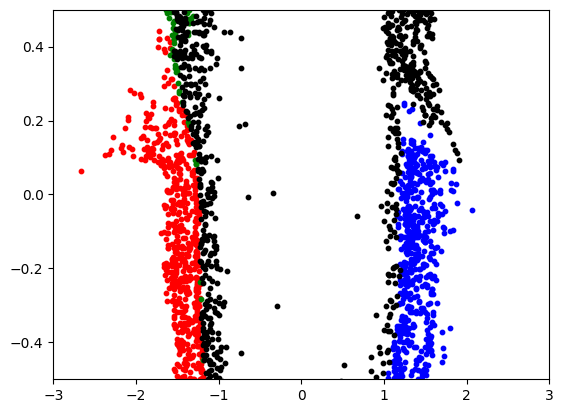

In [61]:
# plot the last one, scaled up
idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] < 0)
plt.scatter(X1[idx, 0], X1[idx, 1], s=10, color='red')
idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] < 0)
plt.scatter(X1[idx, 0], X1[idx, 1], s=10, color='green')
idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] > 0)
plt.scatter(X1[idx, 0], X1[idx, 1], s=10, color='blue')
idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] > 0)
plt.scatter(X1[idx, 0], X1[idx, 1], s=10, color='black')
plt.xlim([-3, 3])
plt.ylim([-.5, .5])
plt.savefig('circles_out.png', dpi=300)

In [ ]:
# model 2: IAF(Inverse Autoregressive Flow)

(-2.0, 2.0)

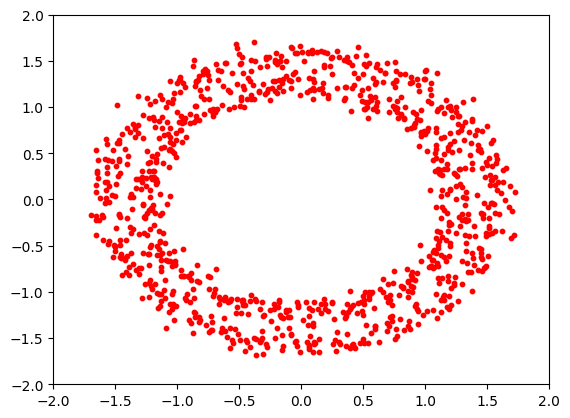

In [ ]:
if TARGET_DENSITY == 'CIRCLES':
    from sklearn import cluster, datasets, mixture
    from sklearn.preprocessing import StandardScaler
    n_samples = 1000
    noisy_circles = datasets.make_circles(n_samples=n_samples, noise=.05)
    X, y = noisy_circles
    X = StandardScaler().fit_transform(X)
    xlim, ylim = [-2, 2], [-2, 2]

plt.scatter(X[:, 0], X[:, 1], s=10, color='red')
plt.xlim(xlim)
plt.ylim(ylim)

In [ ]:
dataset = tf.compat.v1.data.Dataset.from_tensor_slices(X.astype(NP_DTYPE))
dataset = dataset.repeat()
dataset = dataset.shuffle(buffer_size=X.shape[0])
dataset = dataset.prefetch(3 * settings[TARGET_DENSITY]['batch_size'])
dataset = dataset.batch(settings[TARGET_DENSITY]['batch_size'])
data_iterator = dataset.make_one_shot_iterator()
x_samples = data_iterator.get_next()

Instructions for updating:
This is a deprecated API that should only be used in TF 1 graph mode and legacy TF 2 graph mode available through `tf.compat.v1`. In all other situations -- namely, eager mode and inside `tf.function` -- you can consume dataset elements using `for elem in dataset: ...` or by explicitly creating iterator via `iterator = iter(dataset)` and fetching its elements via `values = next(iterator)`. Furthermore, this API is not available in TF 2. During the transition from TF 1 to TF 2 you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)` to create a TF 1 graph mode style iterator for a dataset created through TF 2 APIs. Note that this should be a transient state of your code base as there are in general no guarantees about the interoperability of TF 1 and TF 2 code.


In [6]:
DTYPE=tf.float32
NP_DTYPE=np.float32
MODEL = 'IAF' # Which Normalizing Flow to use. 'NVP' or 'MAF' or 'IAF'
TARGET_DENSITY = 'CIRCLES' # Which dataset to model. 
USE_BATCHNORM = False

In [12]:
# After reusing the same functions as used for MAF, # Construct Flow: 
base_dist = tfd.MultivariateNormalDiag(loc=tf.zeros([2], DTYPE))

Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.


In [13]:
num_bijectors = settings[TARGET_DENSITY]['num_bijectors']
bijectors = []

for i in range(num_bijectors):
    if MODEL == 'NVP':
        bijectors.append(NVPCoupling(D=2, d=1, layer_id=i))
    elif MODEL == 'MAF':
        bijectors.append(tfb.MaskedAutoregressiveFlow(
            shift_and_log_scale_fn=tfb.masked_autoregressive_default_template(
                hidden_layers=[512, 512])))
    elif MODEL == 'IAF':
        bijectors.append(tfb.Invert(tfb.MaskedAutoregressiveFlow(
            shift_and_log_scale_fn=tfb.masked_autoregressive_default_template(
                hidden_layers=[512, 512]))))
    if USE_BATCHNORM and i % 2 == 0:
        # BatchNorm helps to stabilize deep normalizing flows, esp. Real-NVP
        bijectors.append(BatchNorm(name='batch_norm%d' % i))
    bijectors.append(tfb.Permute(permutation=[1, 0]))
# Discard the last Permute layer.
flow_bijector = tfb.Chain(list(reversed(bijectors[:-1])))

Instructions for updating:
`masked_autoregressive_default_template` is deprecated; use `tfp.bijectors.AutoregressiveNetwork`.   Also, please note the section "Variable Tracking" in the documentation for `tfp.bijectors.MaskedAutoregressiveFlow`.


In [14]:
dist = tfd.TransformedDistribution(
    distribution=base_dist,
    bijector=flow_bijector)

In [15]:
# visualization (before training)
x = base_dist.sample(8000)
samples = [x]
names = [base_dist.name]
for bijector in reversed(dist.bijector.bijectors):
    x = bijector.forward(x)
    samples.append(x)
    names.append(bijector.name)

In [16]:
sess.run(tf.compat.v1.global_variables_initializer())

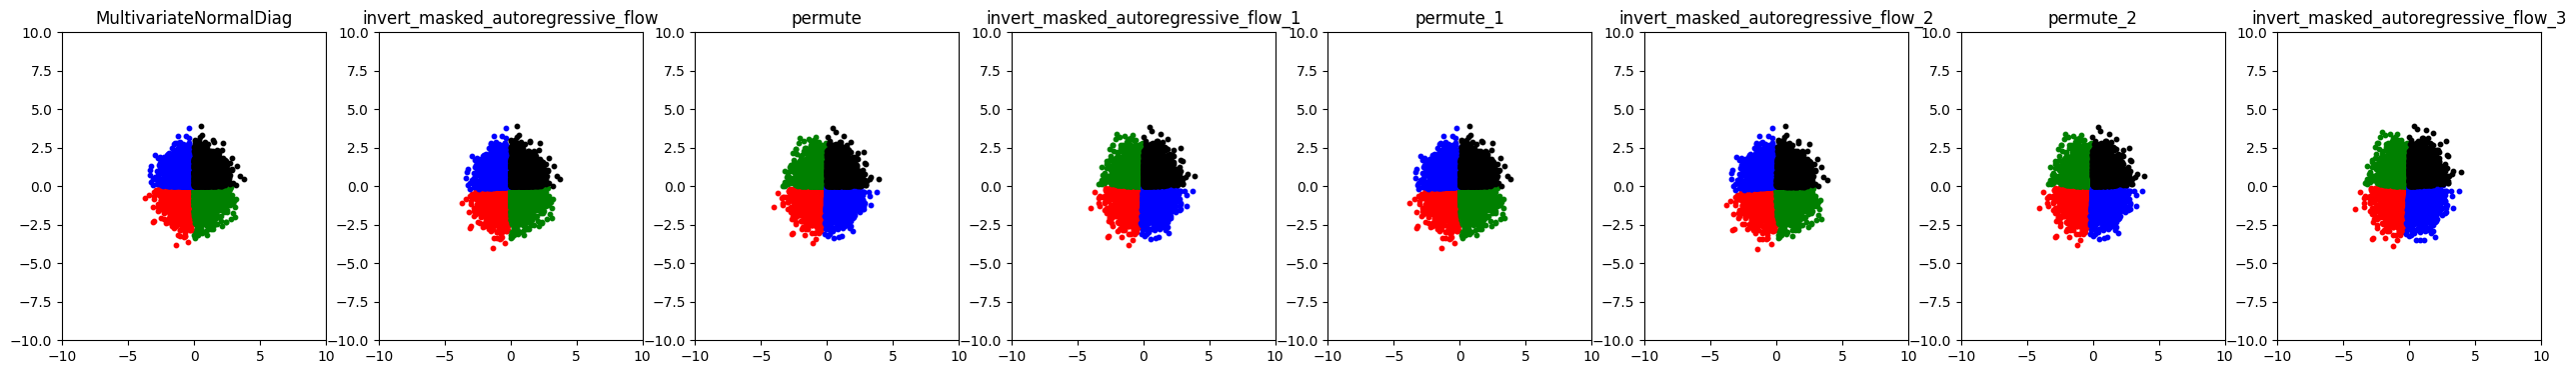

In [17]:
results = sess.run(samples)
f, arr = plt.subplots(1, len(results), figsize=(4 * (len(results)), 4))
X0 = results[0]
for i in range(len(results)):
    X1 = results[i]
    idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] < 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='red')
    idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] < 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='green')
    idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] > 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='blue')
    idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] > 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='black')
    arr[i].set_xlim([-10, 10])
    arr[i].set_ylim([-10, 10])
    arr[i].set_title(names[i])

In [ ]:
# Optimize Flow

In [18]:
loss = -tf.reduce_mean(dist.log_prob(x_samples))
train_op = tf.compat.v1.train.AdamOptimizer(1e-4).minimize(loss)

In [19]:
sess.run(tf.compat.v1.global_variables_initializer())

0 2.826102
10000 1.8805649
20000 2.8002017
30000 2.5865903
40000 5.6878066
50000 9.345401
60000 9.150305
70000 10.941431
80000 nan
90000 nan
100000 nan
110000 nan
120000 nan
130000 nan
140000 nan
150000 nan
160000 nan
170000 nan
180000 nan
190000 nan


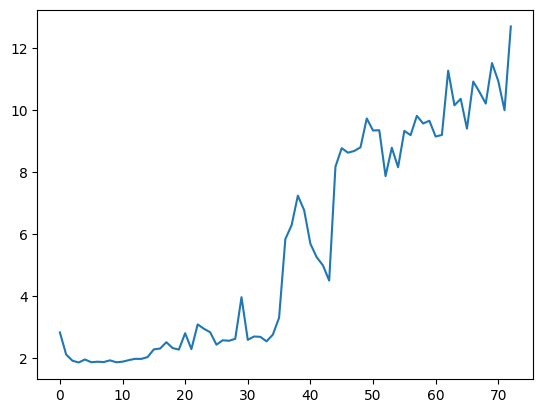

In [20]:
# training the model for 20 epochs and generating loss plot
NUM_STEPS = int(settings[TARGET_DENSITY]['train_iters'])
global_step = []
np_losses = []
for i in range(NUM_STEPS):
    _, np_loss = sess.run([train_op, loss])
    if i % 1000 == 0:
        global_step.append(i)
        np_losses.append(np_loss)
    if i % int(1e4) == 0:
        print(i, np_loss)
start = 0
plt.plot(np_losses[start:])

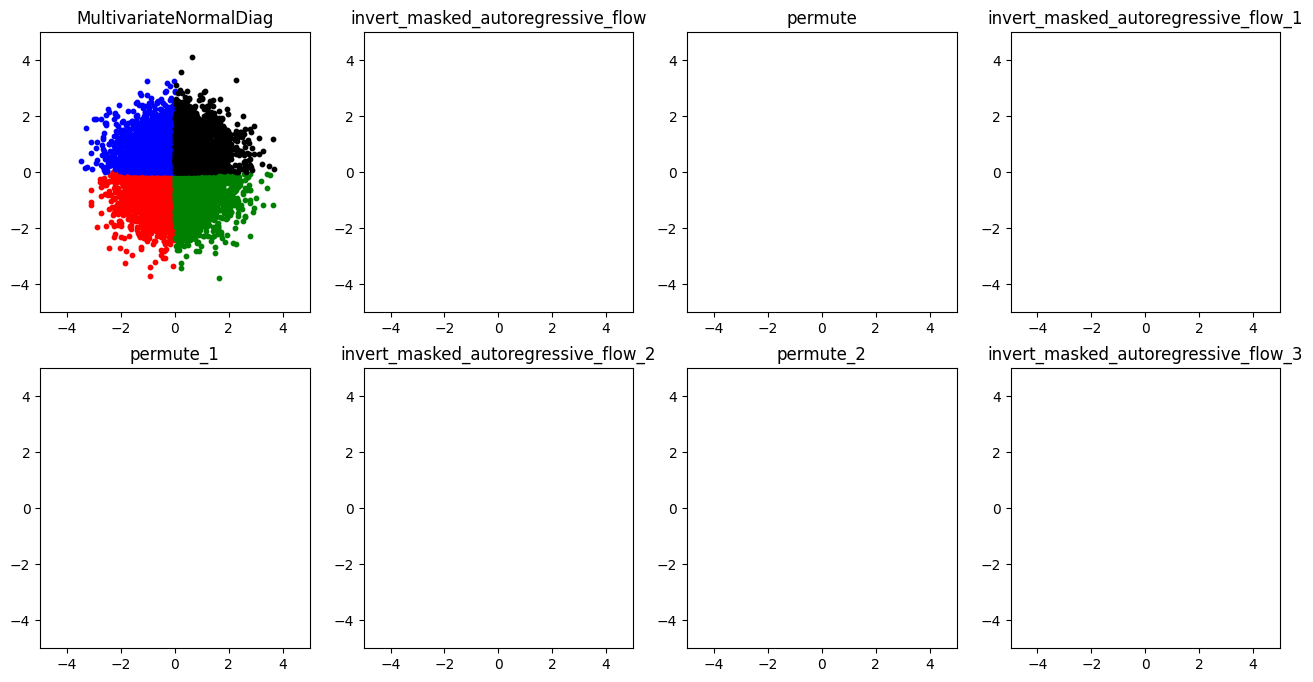

In [21]:
results = sess.run(samples)
X0 = results[0]
rows = 2
cols = int(len(results) / 2)
f, arr = plt.subplots(2, cols, figsize=(4 * (cols), 4 * rows))
i = 0
for r in range(rows):
    for c in range(cols):
        X1 = results[i]
        idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] < 0)
        arr[r, c].scatter(X1[idx, 0], X1[idx, 1], s=10, color='red')
        idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] < 0)
        arr[r, c].scatter(X1[idx, 0], X1[idx, 1], s=10, color='green')
        idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] > 0)
        arr[r, c].scatter(X1[idx, 0], X1[idx, 1], s=10, color='blue')
        idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] > 0)
        arr[r, c].scatter(X1[idx, 0], X1[idx, 1], s=10, color='black')
        arr[r, c].set_xlim([-5, 5])
        arr[r, c].set_ylim([-5, 5])
        arr[r, c].set_title(names[i])

        i += 1
plt.savefig('circles_trained.png', dpi=300)

In [ ]:
# DELIVERABLES:

In [ ]:
# 2. How should the scatter plot of z look like, if the model is able to learn the transforma- tions correctly? 
# How does it actually look like for various choices of the hyperparam- eters (specifically number of layers and 
# the size of hidden layers)? For keeping things simple you can keep the size of hidden layers in each of the layers
#  same.

In [ ]:
# Answer: 
# If the Normalizing Flow model is able to learn the transformations correctly, the scatter plot of z should 
# resemble a 2-dimensional Gaussian distribution centered at the origin (0,0) with unit variance along both axes. 
# This is because the goal of the Normalizing Flow is to transform the input distribution into a standard Gaussian 
# distribution, which is represented by N(0,I2), where 0 is the mean vector and I2 is the 2x2 identity matrix 
# representing unit variance along both axes.
# For various choices of hyperparameters, such as the number of layers and the size of hidden layers, the scatter 
# plot of z may vary. In general, a deeper model with more layers and larger hidden layers may have a more complex 
# representation of the input distribution and may be able to capture more intricate patterns in the data. However, 
# deeper models may also be more prone to overfitting if the dataset is small. On the other hand, shallower models 
# with fewer layers and smaller hidden layers may have a simpler representation of the data and may be less prone 
# to overfitting, but may also have limited capacity to capture complex patterns in the data.
# By analyzing the scatter plots of z, one can gain insights into how well the model is able to learn the 
# transformations and whether the generated z values follow the desired Gaussian distribution centered at the 
# origin with unit variance along both axes.

In [ ]:
# 3. How does the distribution matching between xˆ and x changes as you increase the number of layers? Justify 
# this change qualitatively.

In [ ]:
# Answer:
# As you increase the number of layers in the Normalizing Flow architecture, the distribution matching between xˆ 
# (the generated points from sampled z values) and x (the points from the test-set) is expected to improve. This is 
# because deeper models with more layers have a higher capacity to model complex distributions and capture intricate 
# patterns in the data.
# Qualitatively, the change in distribution matching can be justified as follows:

# One-layer model: A one-layer Normalizing Flow model may have limited capacity to accurately capture the underlying 
# distribution of the data, especially if the data distribution is complex or has multiple modes. As a result, the 
# generated points xˆ from the sampled z values may not fully match the distribution of x from the test-set.

# Three-layer model: A three-layer Normalizing Flow model has more capacity compared to a one-layer model and can 
# learn more complex transformations between x and z. This can result in improved distribution matching between xˆ 
# and x, as the model can capture more complex patterns in the data and generate points that more closely resemble 
# the test-set distribution.

# Five-layer model: A five-layer Normalizing Flow model has even higher capacity compared to a three-layer model and 
# can potentially capture even more complex patterns in the data. This can result in further improved distribution 
# matching between xˆ and x, as the model can better approximate the true data distribution and generate points that 
# closely match the test-set distribution.

# In general, as the number of layers increases in the Normalizing Flow architecture, the model becomes more capable 
# of capturing complex patterns in the data, leading to improved distribution matching between xˆ and x.

In [ ]:
# 4. Keeping the choice of parameters same, which of the datasets is easier to train? Can you guess why?

In [ ]:
# Answer:
# The "moons" dataset is easier to train compared to the "circles" dataset.
# This is because the "moons" dataset has a clear and simple pattern, where the points form two crescent shapes 
# with a noticeable gap between them. The affine coupling layers in the Normalizing Flow model can potentially 
# learn to capture this pattern with relatively fewer layers and smaller hidden layer sizes. The simpler pattern 
# in the "moons" dataset allows for easier modeling and transformation by the neural networks in the affine 
# coupling layers.
# On the other hand, the "circles" dataset has a more complex and intricate pattern, where the points form 
# concentric circles with overlapping regions. This requires the Normalizing Flow model to capture more complex 
# and non-linear transformations between x and z to accurately model the underlying distribution. As a result, 
# the "circles" dataset may require a larger number of layers and larger hidden layer sizes in the neural networks 
# of the affine coupling layers to accurately learn and transform the data distribution, making it comparatively 
# harder to train.